In [1]:
#Load USPS Dataset
import h5py
path="usps.h5"
with h5py.File(path, 'r') as hf:
        train = hf.get('train')
        X_train = train.get('data')[:]
        y_train = train.get('target')[:]
        test = hf.get('test')
        X_test = test.get('data')[:]
        y_test = test.get('target')[:]

#Import libraries 
import numpy as np
import math 
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt 
import time
from sklearn.model_selection import train_test_split
%matplotlib inline

#Split data into training set proper, calibration set and test set
X_train_p, X_cal, y_train_p, y_cal = train_test_split(X_train, y_train, random_state=0)

print("Training Proper Size:", len(X_train_p))
print("Calibration Set Size:",len(X_cal))
print("Test Set Size:",len(X_test))

Training Proper Size: 5468
Calibration Set Size: 1823
Test Set Size: 2007


# 1NN Transductive Point Prediction Algorithm

In [2]:
 def knn_conf_predictor(X_train,y_train,X_test,y_test,k ):
    #Initialize variables for storage
    neigh = NearestNeighbors(n_neighbors=k+1)
    score=np.zeros(len(X_train)+1)
    p_values=np.zeros((len(X_test),len(set(y_train))))
    prediction=np.zeros(len(X_test))
    confidence=np.zeros(len(X_test))
    credibility=np.zeros(len(X_test))
    sum_p_values=0
    #Loop through test samples
    for i in range(len(X_test)):
        #Create new dataset which is the training set + the test sample
        extend_train_X=np.row_stack((X_train,X_test[i]))
        for j in set(y_train): #Test all possible labels
            #Extend labels with test sample
            extend_train_y=np.append(y_train,j)
            conf_scores=[]
            new_X_train=extend_train_X[:len(extend_train_X)-1]
            new_y_train=extend_train_y[:len(extend_train_y)-1]
            for n in range(10):
                same_sample_1=extend_train_X[extend_train_y==n]
                same_sample_2=new_X_train[new_y_train==n]
                neigh.fit(same_sample_1)
                same_scores=neigh.kneighbors(same_sample_2)[0][:,1]
                diff_sample_1=extend_train_X[extend_train_y!=n]
                neigh.fit(diff_sample_1)
                diff_scores=neigh.kneighbors(same_sample_2)[0][:,0]
                conf_scores.extend(same_scores/diff_scores)
            X_sample=extend_train_X[-1]
            y_sample=extend_train_y[-1]
            neigh.fit(extend_train_X[extend_train_y==y_sample])
            NN_dist_s=neigh.kneighbors([X_sample])[0][0][1]
            neigh.fit(extend_train_X[extend_train_y!=y_sample])
            NN_dist_d=np.sum(neigh.kneighbors([X_sample])[0][0][0])
            conf_scores.append(NN_dist_s/NN_dist_d)
            #Calculate p-values of test sample
            p_values[i][j]=np.mean(conf_scores>=conf_scores[-1])
        #Use p-values of test sample to calculate various measures
        prediction[i]=int(np.argmax(p_values[i]))
        confidence[i]=1- p_values[i][np.argsort(p_values[i])[-2]]
        credibility[i]=np.max(p_values[i])
        sum_p_values = sum_p_values + np.sum(p_values[i]) - p_values[i][y_test[i]]
    false_p_value=sum_p_values/(2*len(X_test))
    return prediction, confidence, credibility, false_p_value

In [6]:
start_time = time.time()
one_NN_pred=knn_conf_predictor(X_train,y_train,X_test[0:2],y_test[0:2],1 )
print("--- %s seconds ---" % (time.time() - start_time))

--- 562.9051868915558 seconds ---


In [ ]:
print("Linear SVM Accuracy: ", np.mean(one_NN_pred[0]==y_test))
print("Linear SVM Avg False p-value: ", one_NN_pred[3])
print("Linear Avg Credibility: ",np.mean(one_NN_pred[2]))

# kNN Inductive Point Prediction Algorithm

In [3]:
def knn_induc_conf_predictor(X_train_p,y_train_p,X_cal,y_cal,X_test,y_test,k, smooth ):
    #Initialize variables for storage
    neigh = NearestNeighbors(n_neighbors=k+1)
    score=np.zeros(len(X_train)+1)
    p_values=np.zeros((len(X_test),len(set(y_train))))
    prediction=np.zeros(len(X_test))
    confidence=np.zeros(len(X_test))
    credibility=np.zeros(len(X_test))
    sum_p_values=0
    
    score=[]
    #Calculate the non-conformity scores for the calibration set
    #For each label take all samples with that label and use it in calculating distance to the nearest sample of the
    #same and different labels
    for n in set(y_train_p):
        #Get samples in the training set proper with label n
        same_sample_1=X_train_p[y_train_p==n]
        #Get samples in calibration set with label n
        same_sample_2=X_cal[y_cal==n]
        #Fit nearest neighbours to the training set proper samples with the same label
        neigh.fit(same_sample_1)
        #Get distances for calibration set samples to samples of the same label
        same_scores=neigh.kneighbors(same_sample_2)[0][:,1]
        #Get samples in the training set proper with a different label to n
        diff_sample_1=X_train_p[y_train_p!=n]
        #Fit nearest neighbours to the training set proper samples with the same label
        neigh.fit(diff_sample_1)
        diff_scores=neigh.kneighbors(same_sample_2)[0][:,0]
        score.extend(same_scores/diff_scores)
    #Loop through test samples
    for i in range(len(X_test)):
        for j in set(y_train_p): #Test all possible labels
            neigh.fit(X_train_p[y_train_p==j])
            NN_dist_s=neigh.kneighbors([X_test[i]])[0][0][1]
            neigh.fit(X_train_p[y_train_p!=j])
            NN_dist_d=np.sum(neigh.kneighbors([X_test[i]])[0][0][0])
            score_extend=np.append(score,NN_dist_s/NN_dist_d)
            #Calculate p-values of test sample
            if smooth == True:
                tau=np.random.uniform()
                p_values[i][j]=(np.sum(score_extend>score_extend[-1])+(tau*(np.sum(score_extend==score_extend[-1]))))/len(score_extend)
            else:
                p_values[i][j]=np.mean(score_extend>=score_extend[-1])
        #Use p-values of test sample to calculate various measures
        prediction[i]=int(np.argmax(p_values[i]))
        confidence[i]=1- p_values[i][np.argsort(p_values[i])[-2]]
        credibility[i]=np.max(p_values[i])
        sum_p_values = sum_p_values + np.sum(p_values[i]) - p_values[i][y_test[i]]
    false_p_value=sum_p_values/(2*len(X_test))
    return prediction, confidence, credibility, p_values, false_p_value

In [4]:
start_time = time.time()
one_NN_pred_induc=knn_induc_conf_predictor(X_train_p,y_train_p,X_cal,y_cal,X_test,y_test,1, False )
print("--- %s seconds ---" % (time.time() - start_time))

--- 8324.660489320755 seconds ---


In [16]:
print("Inductive SVM Accuracy: ", np.mean(one_NN_pred_induc[0]==y_test))
print("Inductive SVM Avg False p-value: ", one_NN_pred_induc[4])
print("Inductive Avg Credibility: ",np.mean(one_NN_pred_induc[2]))
print("Inductive Avg Confidence: ",np.mean(one_NN_pred_induc[1]))

Inductive SVM Accuracy:  0.9446935724962631
Inductive SVM Avg False p-value:  0.012879537845610568
Inductive Avg Credibility:  0.47799341558929714
Inductive Avg Confidence:  0.9942711474750653


# 1NN Inductive Validity Curve

In [6]:
error_rate=[]
sigs=[0,0.01,0.05,0.1,0.15,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,1]
#Loop through the different significance level and use p-values to calculate their error rate
for sig in sigs :
    prediction_set=[0] * len(X_test)
    error=0
    for i in range(len(X_test)):
        prediction_set[i]=list(np.where(one_NN_pred_induc[3][i]>(sig))[0])
        if y_test[i] not in prediction_set[i]:
            error+=1
    error_rate=np.append(error_rate,error/len(X_test))

Text(0.5, 1.0, 'Inductive 1NN Validation Curve')

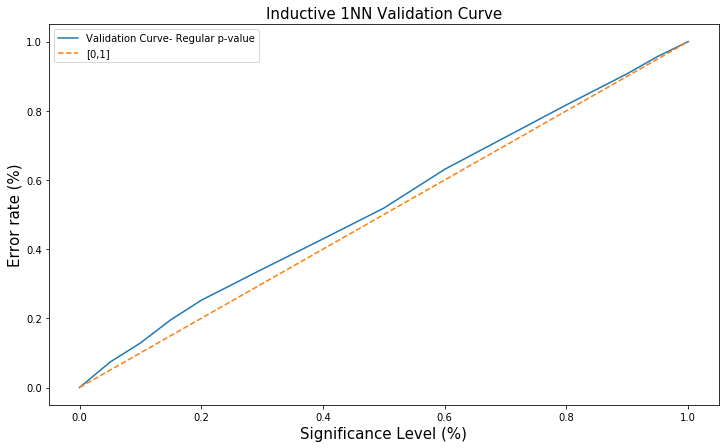

In [7]:
plt.figure(figsize=(12,7))
plt.plot(sigs,error_rate)
plt.plot([0,1],[0,1],"--")
plt.legend(["Validation Curve- Regular p-value","[0,1]"])
plt.xlabel("Significance Level (%)",fontsize=15)
plt.ylabel("Error rate (%)",fontsize=15)
plt.title("Inductive 1NN Validation Curve",fontsize=15)

# 1NN Inductive Smoothed p-value

In [8]:
start_time = time.time()
one_NN_pred_induc_smooth=knn_induc_conf_predictor(X_train_p,y_train_p,X_cal,y_cal,X_test,y_test,1, True )
print("--- %s seconds ---" % (time.time() - start_time))

--- 8043.092978715897 seconds ---


In [9]:
error_rate_smooth=[]
sigs=[0,0.01,0.05,0.1,0.15,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,1]
for sig in sigs :
    prediction_set=[0] * len(X_test)
    error=0
    for i in range(len(X_test)):
        prediction_set[i]=list(np.where(one_NN_pred_induc[3][i]>(sig))[0])
        if y_test[i] not in prediction_set[i]:
            error+=1
    error_rate_smooth=np.append(error_rate_smooth,error/len(X_test))

Text(0.5, 1.0, 'Inductive 1NN Validity Curve')

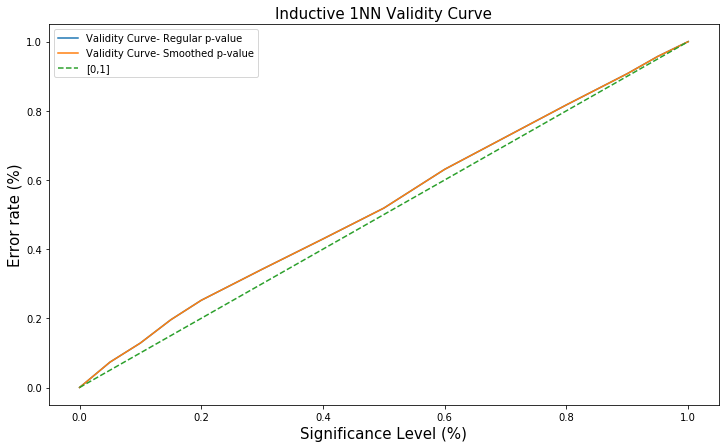

In [11]:
plt.figure(figsize=(12,7))
plt.plot(sigs,error_rate)
plt.plot(sigs,error_rate_smooth)
plt.plot([0,1],[0,1],"--")
plt.legend(["Validity Curve- Regular p-value","Validity Curve- Smoothed p-value","[0,1]"])
plt.xlabel("Significance Level (%)",fontsize=15)
plt.ylabel("Error rate (%)",fontsize=15)
plt.title("Inductive 1NN Validity Curve",fontsize=15)